## **Imports**

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

#Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#Evaluate
from sklearn.metrics import accuracy_score, confusion_matrix,\
roc_auc_score, auc, roc_curve, classification_report, ConfusionMatrixDisplay
#Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

## **Functions**

In [2]:
def transform_categorical (Data_F, cat_list):
    """Func to transform categorical data using LabelEncoder
    Input: data frame
    Output: Transformed data frame"""
    label_encoder = LabelEncoder()
    for i in cat_list:
        Data_F[i]= label_encoder.fit_transform(Data_F[i])
    return Data_F

# Importing Data

In [3]:
df = pd.read_csv("./Data/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
HD_data = df
HD_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


# Visualizing and preprocessing of the data

In [5]:
#Saving column names, depending on their data type
print(HD_data.dtypes)
nam=HD_data.columns.tolist()
categ = HD_data.columns[HD_data.dtypes==object].tolist()+['FastingBS']

nume =[x for x in nam if x not in categ]
nume.remove('HeartDisease')
HD_data_np = HD_data[nume].to_numpy()

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


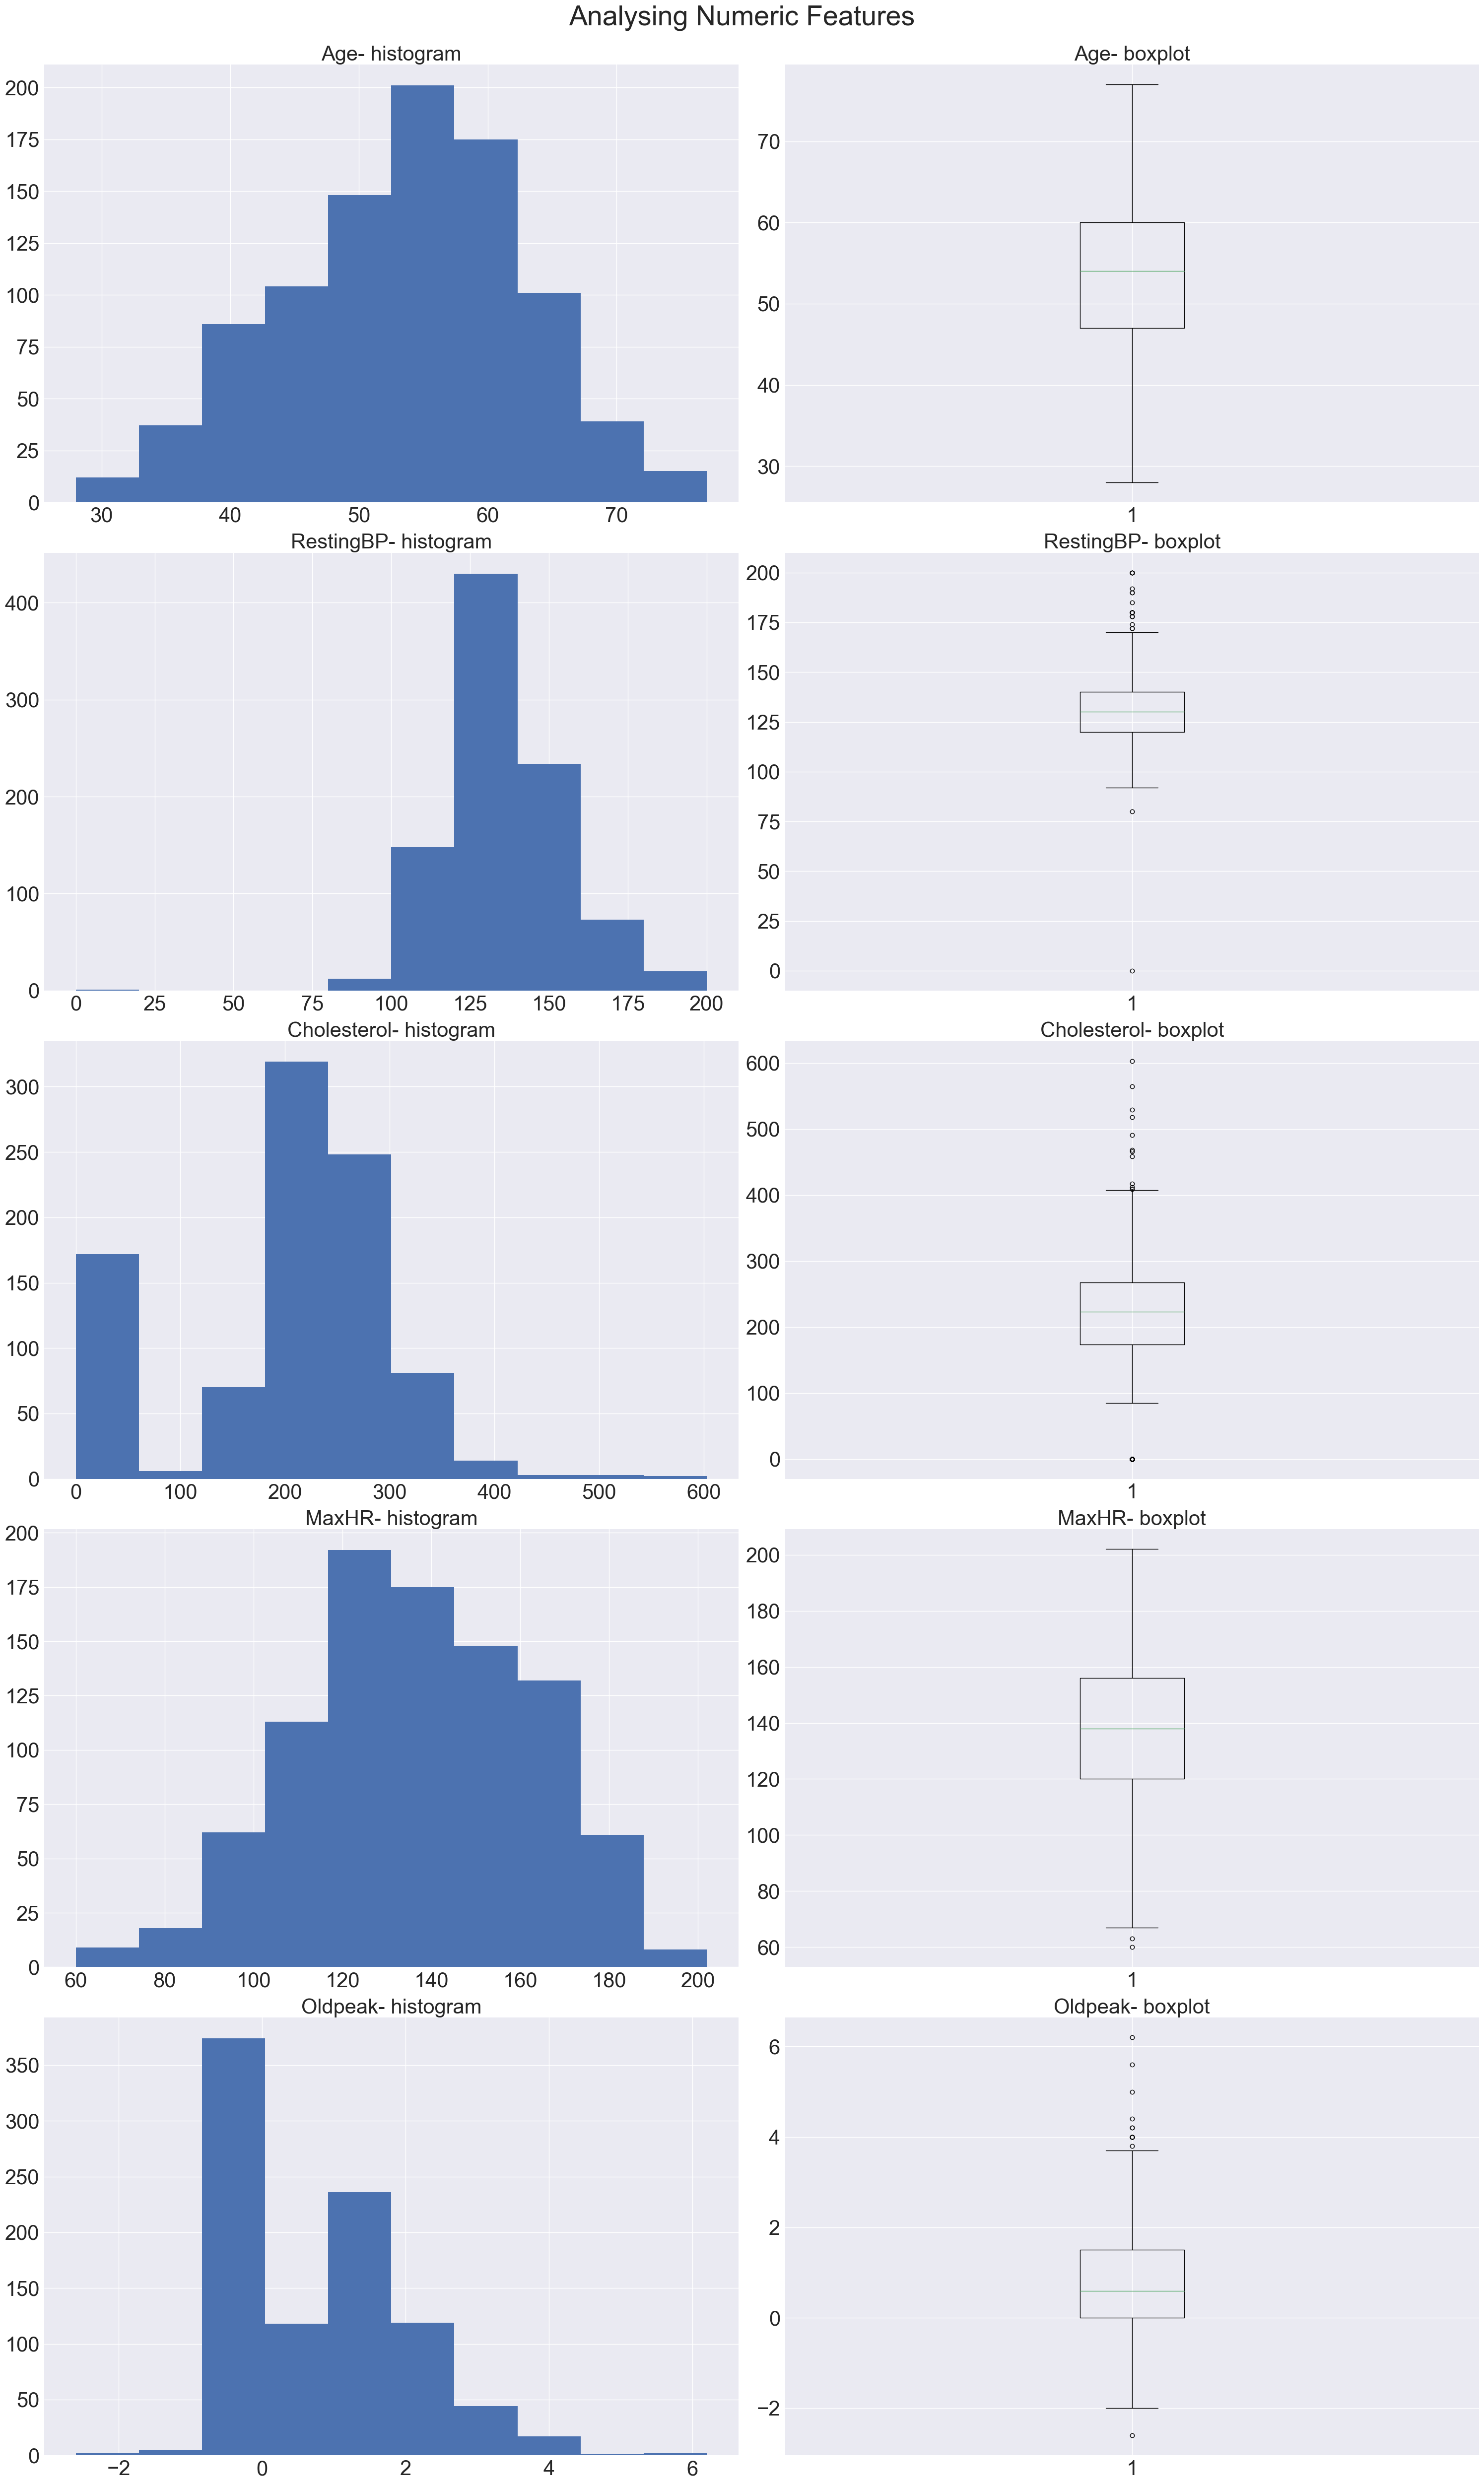

In [6]:
plt.style.use('seaborn')
f, ax = plt.subplots(len(nume),2)
f.set_figheight(50)
f.set_figwidth(30)

for i in range(len(nume)):
    ax[i,0].hist(HD_data_np[:,i])
    ax[i,0].tick_params(labelsize = 30)
    ax[i,0].set_title(nume[i] + '- histogram', fontsize = 30)
    ax[i,1].boxplot(HD_data_np[:,i])
    ax[i,1].tick_params(labelsize = 30)
    ax[i,1].set_title(nume[i] + '- boxplot', fontsize = 30 )
f.suptitle('Analysing Numeric Features',fontsize = 40, y=1)
plt.tight_layout() 
plt.show()

### Managing categorical Data
Transform categorical variables using LabelEncoder function, categories were changed the following way: \
Sex: M-1, F-0\
ChestPainType: ASY-0, ATA-1, NAP-2, TA-3\
RestingECG: LVH-0, Normal-1, ST-2\
ExerciseAngina: N-0 ,Y-1 \
ST_Slope: Down-0, Flat-1, Up-2 





In [7]:
HD_data_t = transform_categorical(HD_data, categ)


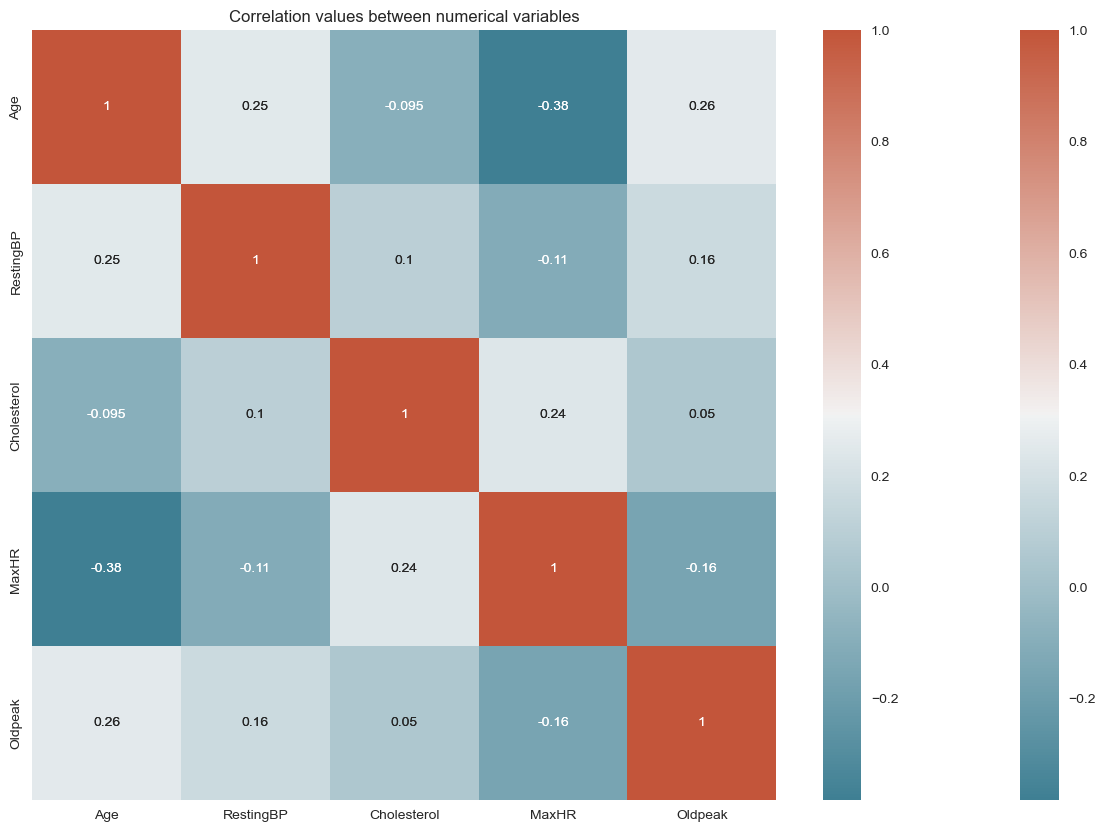

In [8]:
#Correlation plot data with outliers
corr = HD_data_t[nume].corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
sns.heatmap(corr, xticklabels=corr.columns,
            yticklabels=corr.columns, 
            annot=True,
            cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation values between numerical variables')
plt.show()

Datas to use: HD_data_c_t for transformed without outliers, and HD_data_t for transformed with outliers.



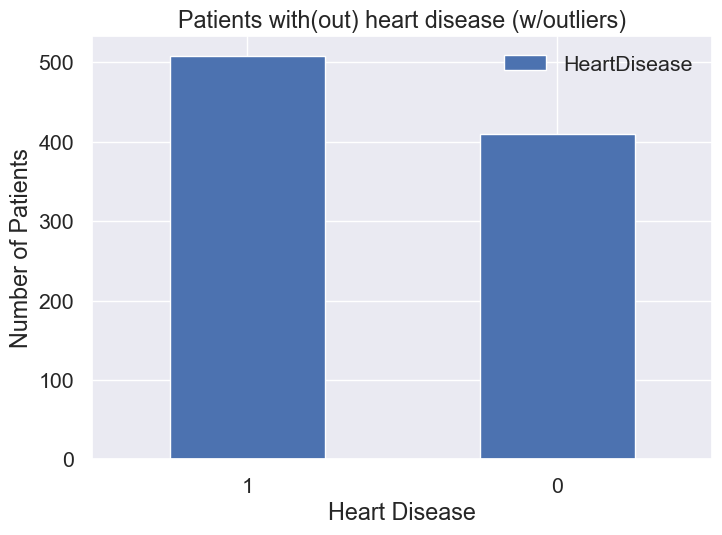

1    508
0    410
Name: HeartDisease, dtype: int64


In [9]:
# Checking class imbalance with outliers
sns.set(font_scale=1.4)
HD_data_t['HeartDisease'].value_counts().plot(kind='bar', rot=0)
plt.title('Patients with(out) heart disease (w/outliers)')
plt.legend()
plt.xlabel("Heart Disease")
plt.ylabel("Number of Patients")
plt.show()
print(HD_data_t['HeartDisease'].value_counts())

In [10]:
# Spliting the data
y = HD_data_t['HeartDisease']
X = HD_data_t.drop('HeartDisease', axis = 1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, \
train_size=0.7, random_state=1, stratify = y)
X_train.shape, X_test.shape

((642, 11), (276, 11))

In [12]:
# Parameter search grid 
dtc = DecisionTreeClassifier(random_state=1)
params = {'max_depth': [int(x) for x in np.linspace(5, 110, num = 10)],
          'min_samples_leaf': [5,10,20,50,100,110],
          'min_samples_split': [2, 5, 10],
          'criterion':['gini','entropy']
        }

In [13]:
# Fitting for data with outliers
dt_class = GridSearchCV(estimator=dtc, param_grid=params, 
                        cv=10, verbose=1, scoring = "accuracy")
dtc_gs = dt_class.fit(X_train,y_train)
f_param = dtc_gs.best_estimator_.get_params()
print(f_param)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 1, 'splitter': 'best'}


In [14]:
dtc= DecisionTreeClassifier(criterion= 'gini', max_depth= 5, min_samples_leaf = 5, min_samples_split =2, random_state= 1)
dtc.fit(X_train,y_train)
y_test_pred = dtc.predict(X_test)
y_train_pred = dtc.predict(X_train)

In [15]:
print(accuracy_score(y_train_pred, y_train))
print(accuracy_score(y_test_pred, y_test))
print(params)

0.9080996884735203
0.8152173913043478
{'max_depth': [5, 16, 28, 40, 51, 63, 75, 86, 98, 110], 'min_samples_leaf': [5, 10, 20, 50, 100, 110], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']}


              precision    recall  f1-score   support

           0       0.86      0.93      0.89       264
           1       0.95      0.89      0.92       378

    accuracy                           0.91       642
   macro avg       0.90      0.91      0.91       642
weighted avg       0.91      0.91      0.91       642



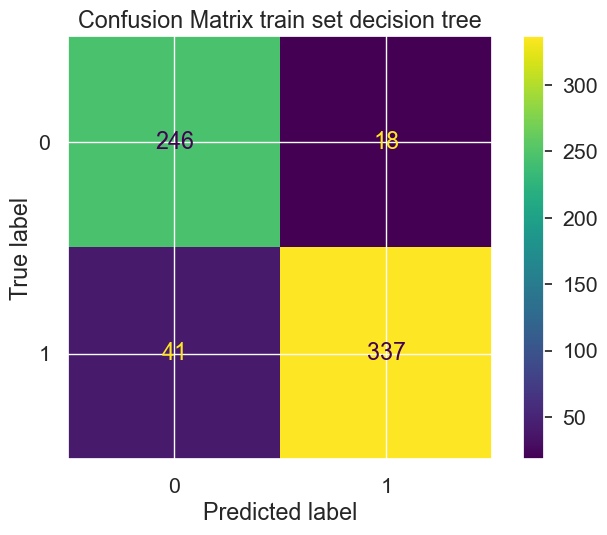

In [42]:
print(classification_report(y_train_pred, y_train))
cm = confusion_matrix(y_train_pred, y_train, labels=dtc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                        display_labels=dtc.classes_)
disp.plot()
plt.title('Confusion Matrix train set decision tree')
plt.show()

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       104
           1       0.90      0.80      0.84       172

    accuracy                           0.82       276
   macro avg       0.81      0.82      0.81       276
weighted avg       0.83      0.82      0.82       276



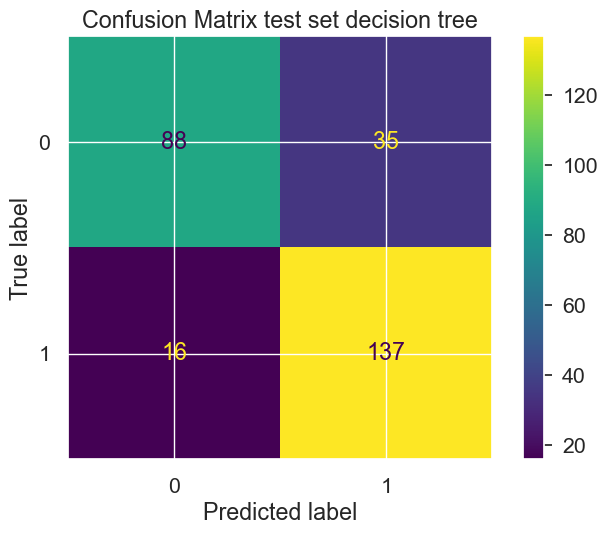

In [41]:
print(classification_report(y_test_pred, y_test))
cm = confusion_matrix(y_test,y_test_pred, labels=dtc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                        display_labels=dtc.classes_)
disp.plot()
plt.title('Confusion Matrix test set decision tree')
plt.show()

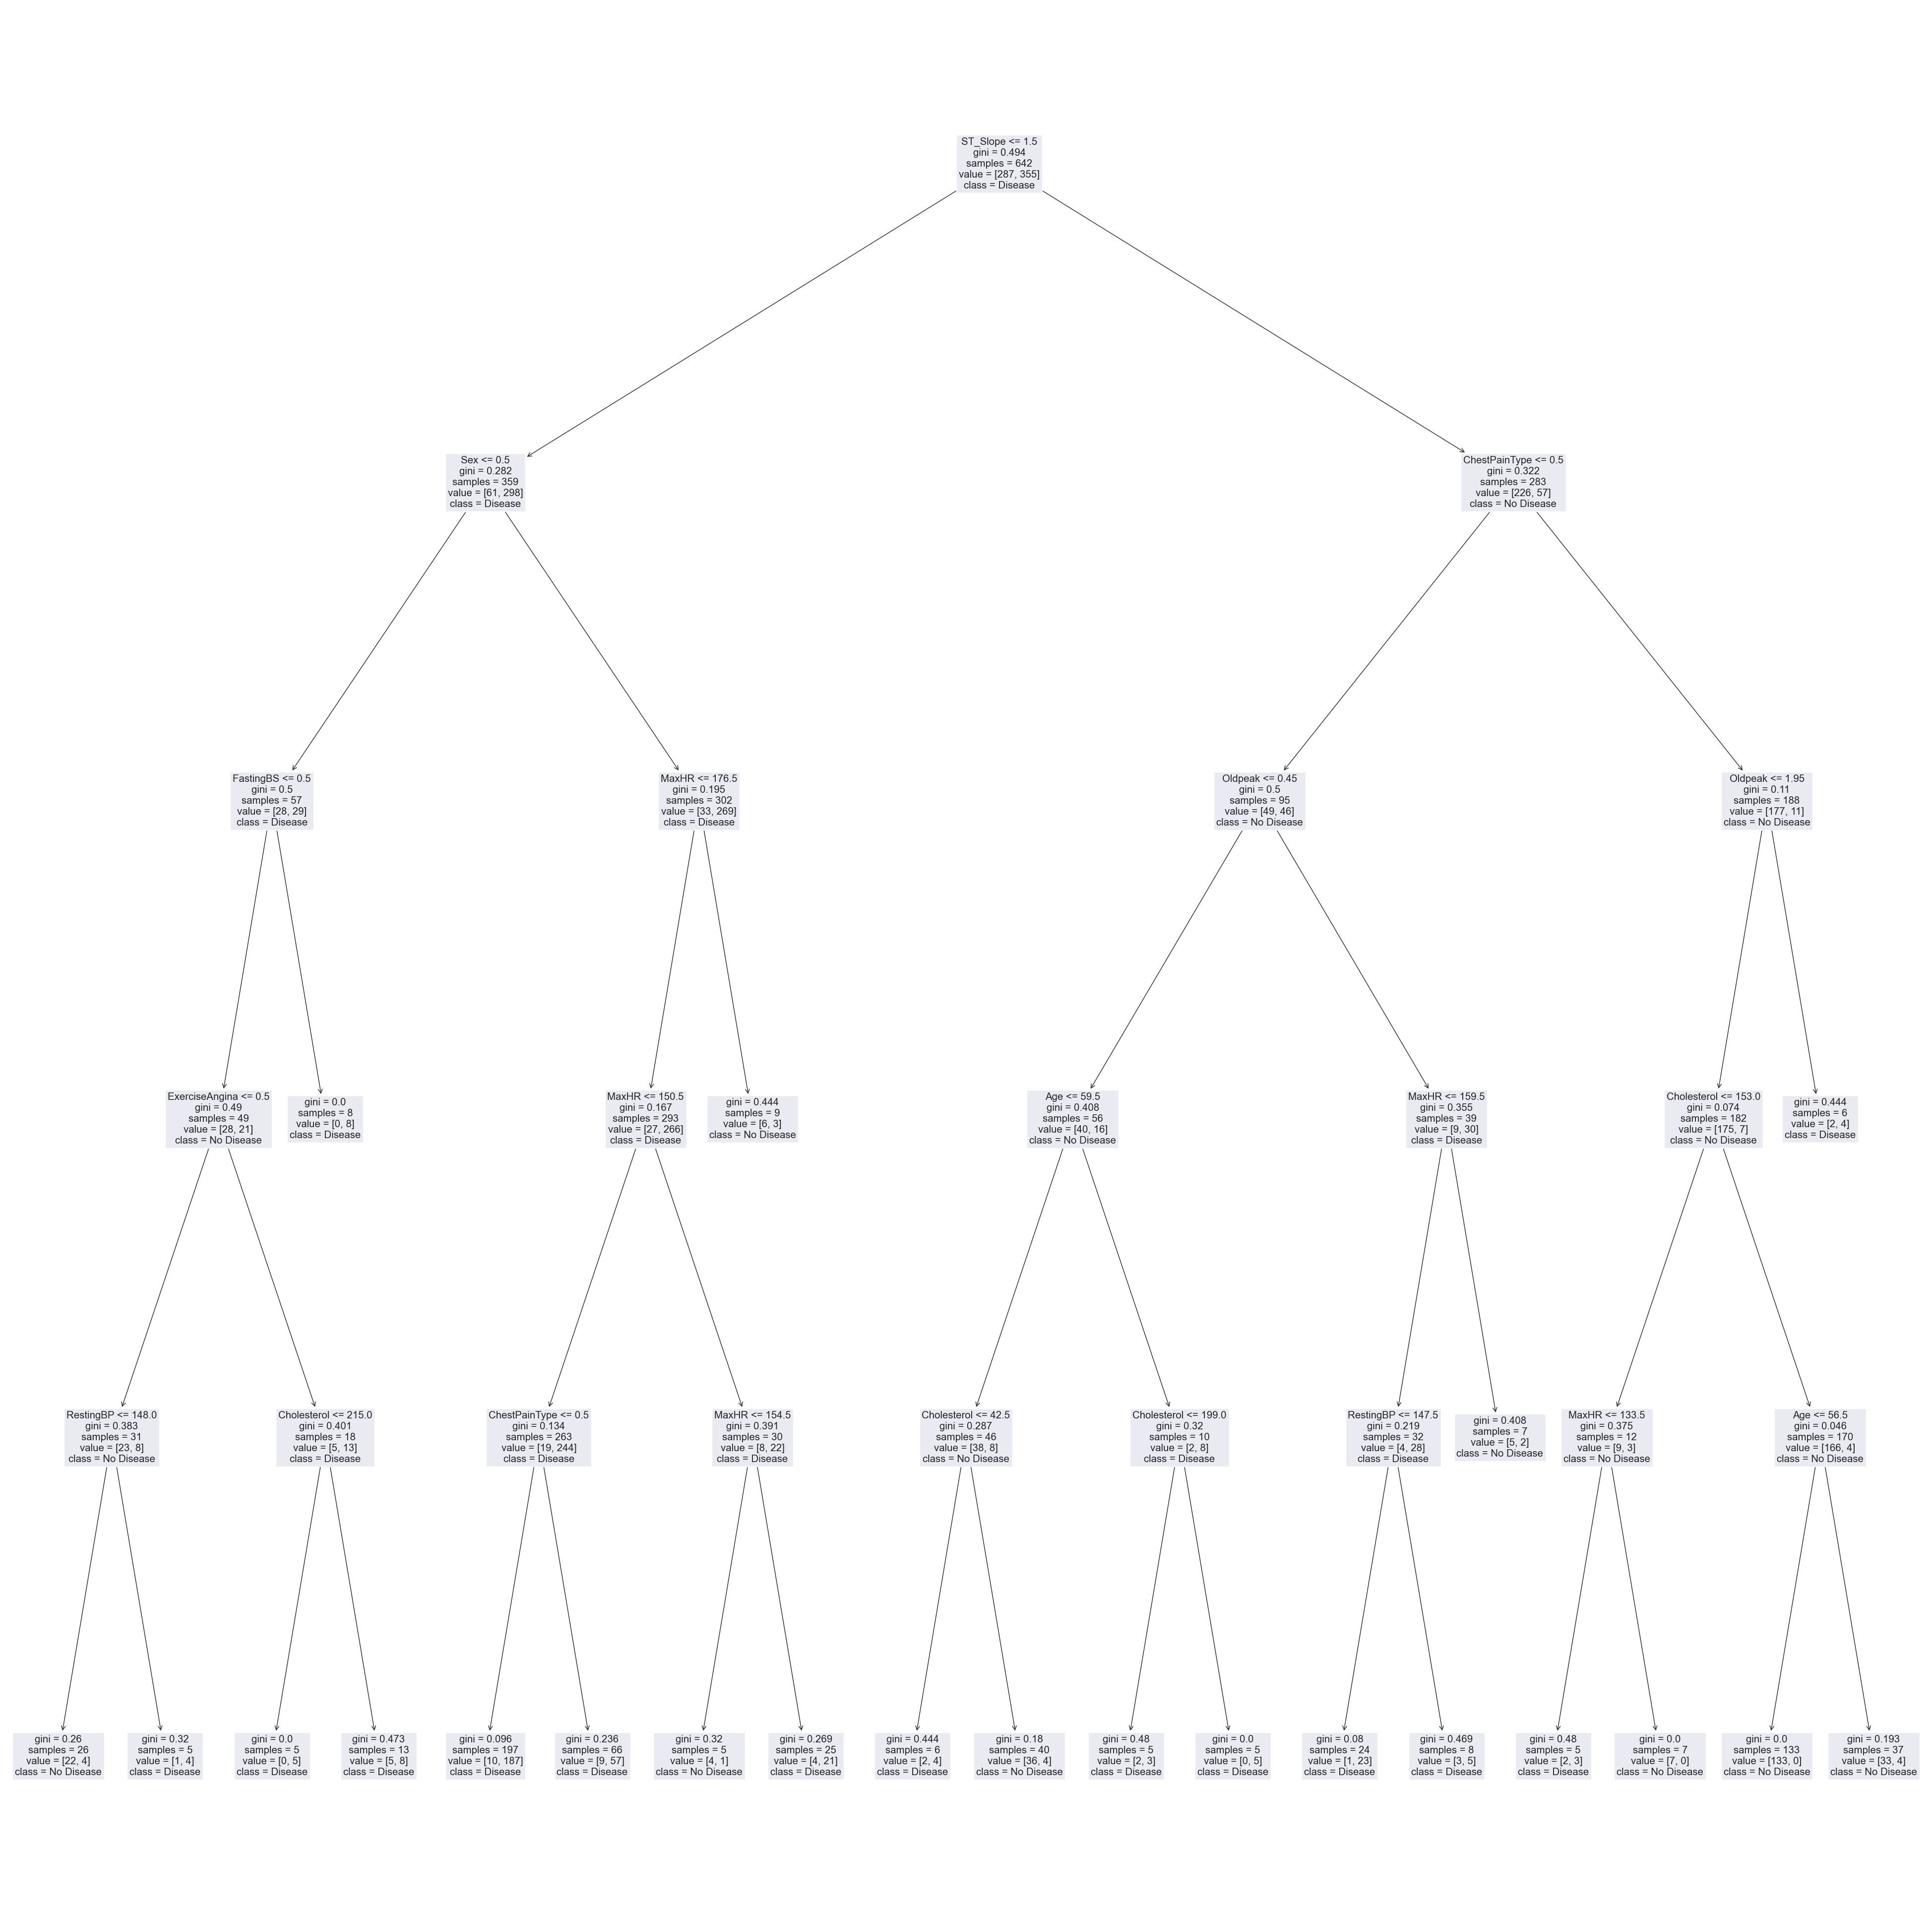

In [18]:
plt.figure(figsize=(50, 50))
tree.plot_tree(dtc, feature_names = nam[0:11], class_names = ['No Disease','Disease'])
plt.show()

Age , 0.03191
Sex , 0.06273
ChestPainType , 0.10580
RestingBP , 0.02168
Cholesterol , 0.02856
FastingBS , 0.02014
RestingECG , 0.00000
MaxHR , 0.07758
ExerciseAngina , 0.02200
Oldpeak , 0.06875
ST_Slope , 0.56086


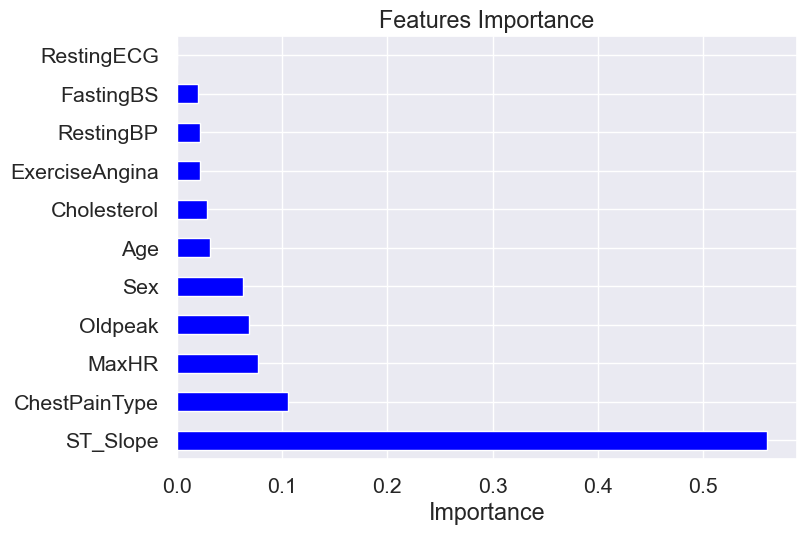

In [19]:
#feature importance
imp = dtc.feature_importances_
for i,v in enumerate(imp):
    aux = X.columns[i]
    print(aux,', %.5f' % v)

importance = pd.Series(imp, index=X.columns)
importance.nlargest(13).plot(kind='barh', colormap='winter')
plt.title('Features Importance')
plt.xlabel('Importance')
plt.show()

AUC: 0.805435995536426
AUC: 0.9032193158953723


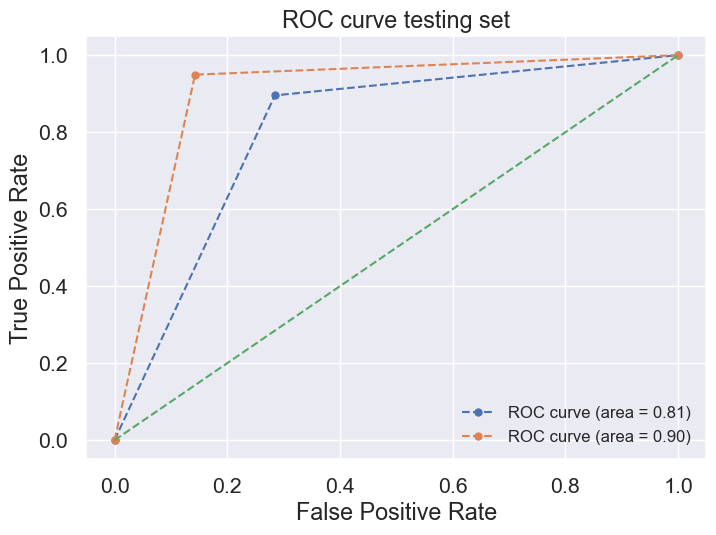

In [20]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test,y_test_pred)
fprt, tprt, thresholdst = roc_curve(y_train,y_train_pred)

roc_auc = auc(fpr, tpr)
print("AUC: {}".format(roc_auc))

roc_auct = auc(fprt, tprt)
print("AUC: {}".format(roc_auct))


plt.plot(fpr, tpr , '--o', label = 'ROC curve (area = %0.2f)'% (roc_auc))
plt.plot(fprt, tprt , '--o', label = 'ROC curve (area = %0.2f)'% (roc_auct))
plt.plot([0,1], [0,1], '--')
plt.legend(fontsize=12)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve testing set')
plt.show()

### Managing outliers
Created a copy of the data so we can see how different decision tree performs deppending if lower bound outliers are removed.


In [21]:
HD_data_c = HD_data.copy()

In [22]:
# 173 patients(rows) were droped from the filtering
index = HD_data_c[(HD_data_c['Cholesterol']==0)|(HD_data_c['RestingBP']==0)|(HD_data_c['Oldpeak']<0)].index
HD_data_c.drop(index, inplace=True)
print(HD_data_c.describe())

              Age         Sex  ChestPainType   RestingBP  Cholesterol  \
count  745.000000  745.000000     745.000000  745.000000   745.000000   
mean    52.906040    0.755705       0.838926  133.036242   244.747651   
std      9.489625    0.429957       0.957898   17.290451    59.113689   
min     28.000000    0.000000       0.000000   92.000000    85.000000   
25%     46.000000    1.000000       0.000000  120.000000   208.000000   
50%     54.000000    1.000000       1.000000  130.000000   237.000000   
75%     59.000000    1.000000       2.000000  140.000000   275.000000   
max     77.000000    1.000000       3.000000  200.000000   603.000000   

        FastingBS  RestingECG       MaxHR  ExerciseAngina     Oldpeak  \
count  745.000000  745.000000  745.000000      745.000000  745.000000   
mean     0.167785    0.930201  140.209396        0.385235    0.902953   
std      0.373927    0.631148   24.536108        0.486978    1.072953   
min      0.000000    0.000000   69.000000        0

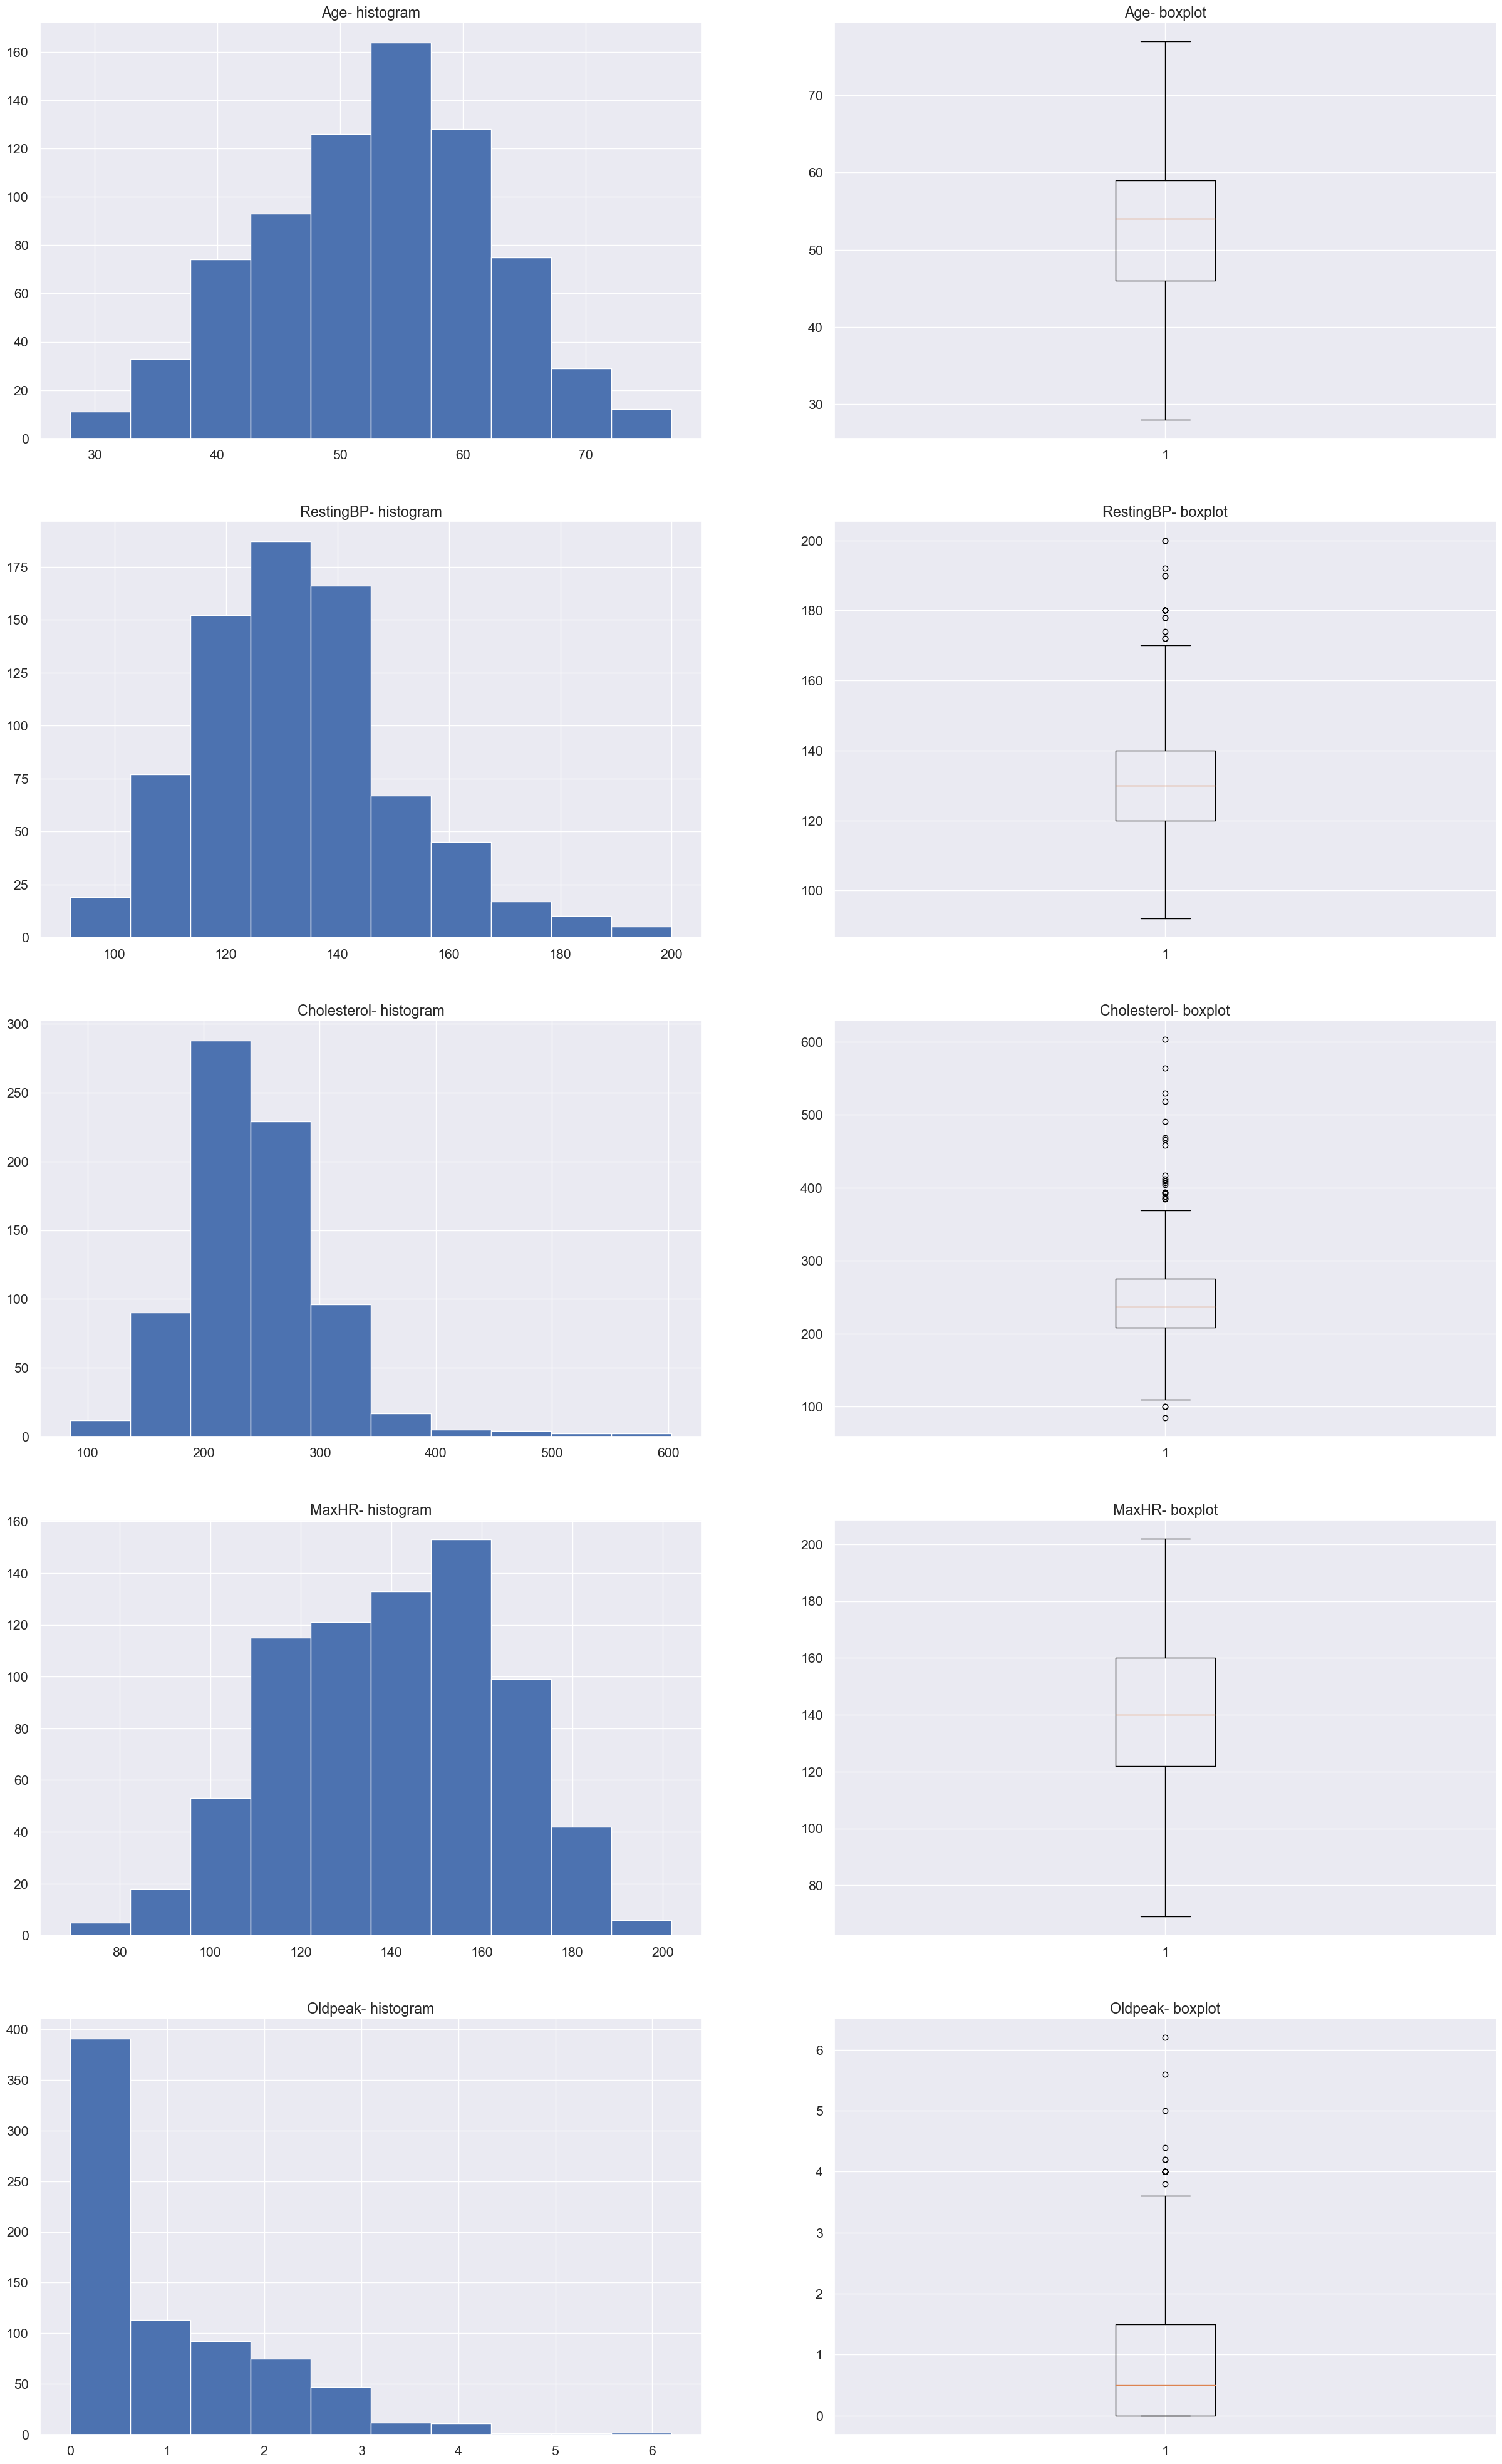

In [23]:
#Processed data histogram and boxplot
HD_data_c_np = HD_data_c[nume].to_numpy()

f, ax = plt.subplots(len(nume),2)
f.set_figheight(50)
f.set_figwidth(30)

for i in range(len(nume)):
    ax[i,0].hist(HD_data_c_np[:,i])
    ax[i,0].set_title(nume[i] + '- histogram')
    ax[i,1].boxplot(HD_data_c_np[:,i])
    ax[i,1].set_title(nume[i] + '- boxplot')

plt.show() 

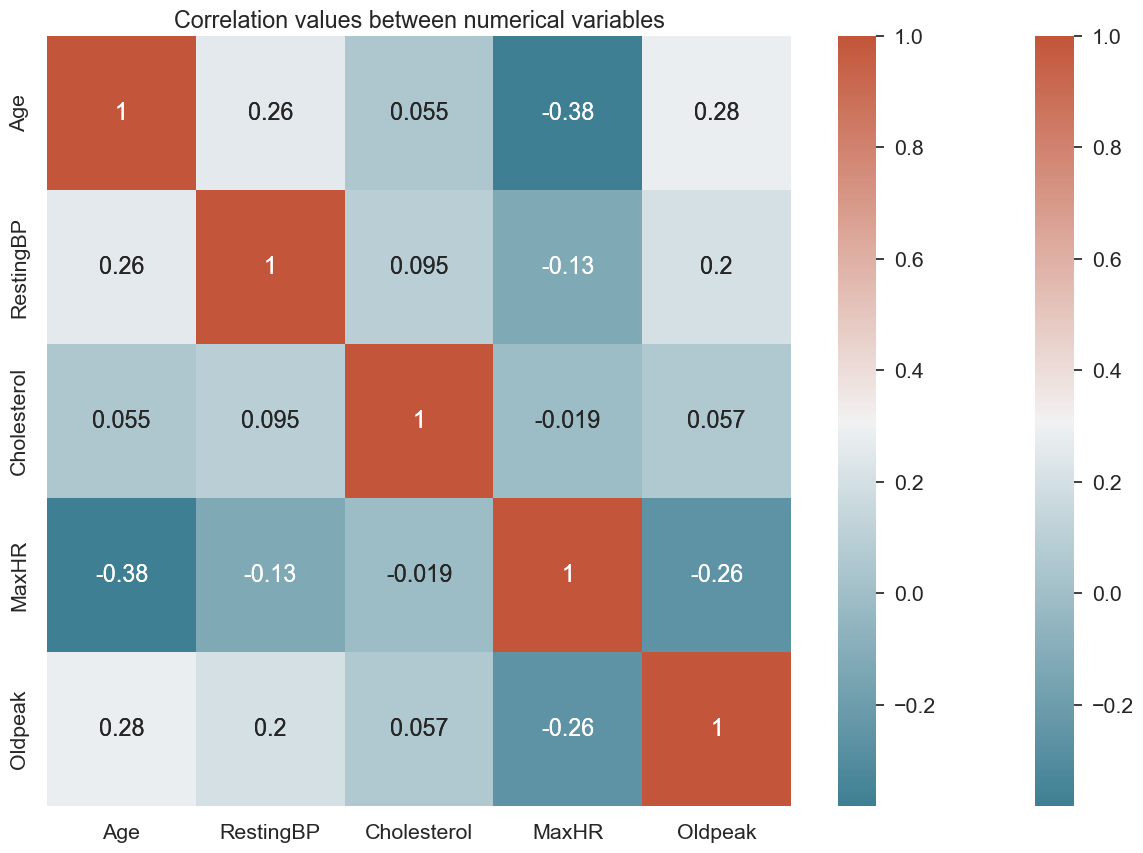

In [25]:
HD_data_c_t = transform_categorical(HD_data_c, categ)
#Correlation plot data without outliers
corr = HD_data_c_t[nume].corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
sns.heatmap(corr, xticklabels=corr.columns,
            yticklabels=corr.columns, 
            annot=True,
            cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation values between numerical variables')
plt.show()

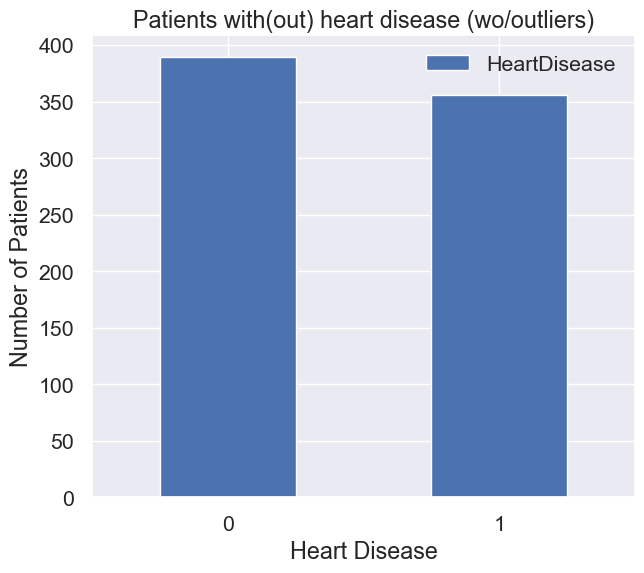

1    508
0    410
Name: HeartDisease, dtype: int64


In [26]:
#without outliers
sns.set(font_scale=1.4)
HD_data_c_t['HeartDisease'].value_counts().plot(kind='bar',figsize=(7,6), rot=0)
plt.title('Patients with(out) heart disease (wo/outliers)')
plt.legend()
plt.xlabel("Heart Disease")
plt.ylabel("Number of Patients")
plt.show()
print(HD_data_t['HeartDisease'].value_counts())

In [27]:
# Spliting the data copy
y_c = HD_data_c_t['HeartDisease']
X_c = HD_data_c_t.drop('HeartDisease', axis = 1)

In [28]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, \
train_size=0.7, random_state=1, stratify = y_c)
X_train_c.shape, X_test_c.shape

((521, 11), (224, 11))

In [29]:
# Fitting for data without outliers
dt_class_c = GridSearchCV(estimator=dtc, param_grid=params, 
                        cv=10, verbose=1, scoring = "accuracy")
dtc_gs_c = dt_class_c.fit(X_train_c,y_train_c)
f_param_c = dtc_gs_c.best_estimator_.get_params()
y_pred_c = dtc_gs_c.predict(X_test_c)
y_pred_ta_c = dtc_gs_c.predict(X_train_c)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


In [30]:
print(f_param_c)
print(accuracy_score(y_pred_ta_c, y_train_c))
print(accuracy_score(y_pred_c, y_test_c))

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 1, 'splitter': 'best'}
0.8867562380038387
0.8035714285714286
